In [4]:
import pandas as pd
import numpy as np
from numpy import expand_dims
import keract
from tensorflow import keras
from tensorflow.keras import applications
from tensorflow.keras import optimizers
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.layers import Dense, Flatten, Dropout, BatchNormalization
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from keras_contrib.callbacks import CyclicLR

In [5]:
train_data_dir = 'C:/Users/sarve/Downloads/marketgrad/tiny-imagenet-200/train'  
validation_data_dir = 'C:/Users/sarve/Downloads/marketgrad/tiny-imagenet-200/val' 
test_data_dir = "C:/Users/sarve/Downloads/marketgrad/tiny-imagenet-200/test"

In [6]:
img_width, img_height = 64, 64 
channels = 3
batch_size = 64

In [7]:
val_data = pd.read_csv(validation_data_dir + '/val_annotations.txt', sep='\t', header=None, names=['File', 'Class', 'X', 'Y', 'H', 'W'])
val_data.drop(['X', 'Y', 'H', 'W'], axis=1, inplace=True)
val_data.head(3)

,File,Class
0,val_0.JPEG,n03444034
1,val_1.JPEG,n04067472
2,val_2.JPEG,n04070727


In [9]:
train_datagen = ImageDataGenerator(
    rescale= 1./255,
    shear_range= 0.2,
    zoom_range= 0.2,
    horizontal_flip= True,
    rotation_range= 20,
    width_shift_range= 0.2,
    height_shift_range= 0.2,
)

datagen = ImageDataGenerator(rescale= 1./255)

In [10]:
train_generator = train_datagen.flow_from_directory(  
    train_data_dir,  
    target_size= (img_width, img_height), 
    color_mode= 'rgb',
    batch_size= batch_size,  
    class_mode= 'categorical',
    shuffle= True, 
    seed= 42
) 

valid_generator = datagen.flow_from_dataframe(
    dataframe= val_data, 
    directory= validation_data_dir + '/images',
    x_col= 'File', 
    y_col= 'Class', 
    target_size= (img_width, img_height),
    color_mode= 'rgb', 
    class_mode= 'categorical', 
    batch_size= batch_size, 
    shuffle= True, 
    seed= 42
)

test_generator = datagen.flow_from_directory(  
    test_data_dir,  
    target_size= (img_width, img_height), 
    color_mode= 'rgb',
    batch_size= batch_size,
    class_mode= None,
    shuffle= False, 
)

Found 100000 images belonging to 200 classes.
Found 10000 validated image filenames belonging to 200 classes.
Found 10000 images belonging to 1 classes.


In [11]:
num_classes = len(train_generator.class_indices)  
train_labels = train_generator.classes 
train_labels = to_categorical(train_labels, num_classes=num_classes)
valid_labels = valid_generator.classes 
valid_labels = to_categorical(valid_labels, num_classes=num_classes)
nb_train_samples = len(train_generator.filenames)  
nb_valid_samples = len(valid_generator.filenames)
nb_test_samples = len(test_generator.filenames)

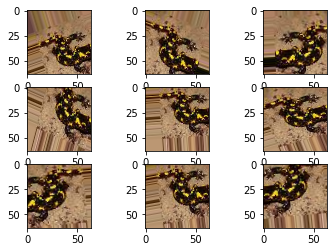

In [12]:
img = load_img("C:/Users/sarve/Downloads/marketgrad/tiny-imagenet-200/train/n01629819/images/n01629819_3.JPEG")
data = img_to_array(img)
samples = expand_dims(data, 0)
it = train_datagen.flow(samples, batch_size=1)

for i in range(9):
    plt.subplot(330 + 1 + i)
    batch = it.next()
    image = batch[0]
    plt.imshow(image)

plt.savefig('augmented_image.png', transparent= True, bbox_inches= 'tight', dpi= 900)
plt.show()

In [13]:
vgg16 = applications.VGG16(include_top= False, input_shape= (img_width, img_height, channels), weights= 'imagenet')
vgg16.summary()

58892288/58889256 [==============================] - 19s 0us/step
Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 64, 64, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 64, 64, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 64, 64, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 32, 32, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 32, 32, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 32, 32, 128)       147584    
_____________________________________________________________

In [14]:
model = Sequential()

for layer in vgg16.layers:
    model.add(layer)

for layer in model.layers:
    layer.trainable= False

model.add(Flatten(input_shape= (2, 2, 512)))

model.add(Dense(512, activation= 'relu', name= 'FC1'))
model.add(BatchNormalization())
model.add(Dropout(0.4))

model.add(Dense(512, activation= 'relu', name= 'FC2'))
model.add(BatchNormalization())
model.add(Dropout(0.4))

model.add(Dense(200, activation= 'softmax', name= 'FC3'))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
block1_conv1 (Conv2D)        (None, 64, 64, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 64, 64, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 32, 32, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 32, 32, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 32, 32, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 16, 16, 128)       0         
_________________________________________________________________
block3_conv1 (Conv2D)        (None, 16, 16, 256)       2

In [15]:
model.compile(optimizer= keras.optimizers.Adam(lr= 0.0001, epsilon= 1e-08), loss= 'categorical_crossentropy', metrics= ['accuracy'])

In [16]:
my_callbacks = [
    EarlyStopping(monitor= 'val_accuracy', mode= 'auto', patience=2),
    CyclicLR(base_lr=0.0001, max_lr=0.0006, step_size=1404., mode= 'triangular2'),
    ModelCheckpoint(filepath= 'baseline_model.h5', monitor= 'val_accuracy', save_best_only= True, mode= 'auto')
]

In [17]:
history = model.fit(
    train_generator, 
    epochs= 30,
    steps_per_epoch = nb_train_samples//batch_size, 
    validation_data = valid_generator, 
    validation_steps = nb_valid_samples//batch_size,
    verbose = 2, 
    callbacks = my_callbacks,
    shuffle = True
)

Epoch 1/30
1562/1562 - 1128s - loss: 4.8714 - accuracy: 0.0703 - val_loss: 3.5476 - val_accuracy: 0.2114
Epoch 2/30
1562/1562 - 1126s - loss: 3.9424 - accuracy: 0.1510 - val_loss: 3.2610 - val_accuracy: 0.2623
Epoch 3/30
1562/1562 - 1128s - loss: 3.7758 - accuracy: 0.1750 - val_loss: 3.2133 - val_accuracy: 0.2680
Epoch 4/30
1562/1562 - 1130s - loss: 3.6556 - accuracy: 0.1935 - val_loss: 3.1267 - val_accuracy: 0.2847
Epoch 5/30
1562/1562 - 1134s - loss: 3.5944 - accuracy: 0.2050 - val_loss: 3.0969 - val_accuracy: 0.2881
Epoch 6/30
1562/1562 - 1143s - loss: 3.5323 - accuracy: 0.2130 - val_loss: 3.0614 - val_accuracy: 0.2987
Epoch 7/30
1562/1562 - 1226s - loss: 3.5112 - accuracy: 0.2169 - val_loss: 3.0424 - val_accuracy: 0.2996
Epoch 8/30
1562/1562 - 1224s - loss: 3.4642 - accuracy: 0.2249 - val_loss: 3.0076 - val_accuracy: 0.3044
Epoch 9/30
1562/1562 - 1232s - loss: 3.4481 - accuracy: 0.2286 - val_loss: 2.9905 - val_accuracy: 0.3105
Epoch 10/30
1562/1562 - 1182s - loss: 3.4208 - accuracy

KeyboardInterrupt: 

In [25]:
(eval_loss, eval_accuracy) = model.evaluate(valid_generator, batch_size= batch_size, verbose= 1)
print('Validation Loss: ', eval_loss)
print('Validation Accuracy: ', eval_accuracy)
#to be honest if just more epochs were there then probably, the accuracy would have increased.

157/157 [==============================] - 98s 625ms/step - loss: 2.9796 - accuracy: 0.3083
Validation Loss:  2.979604721069336
Validation Accuracy:  0.3082999885082245


In [ ]:
#given that it runs off from my CPU, A GPU is more preferable